In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
import sqlite3


In [2]:
def select_by(db, name, type):

    S = """select s1.ts,s1.type,s1.tid,s1.iter,(s2.ts-s1.ts),s1.heap,s2.heap,s1.details
  from stats s1 inner join stats s2 on s1.tid=s2.tid and s1.iter=s2.iter and s1.action!=s2.action and s1.type=s2.type
 where s1.type='{type}' and s1.action='start' and s1.name = '{name}' and s2.name = '{name}'
 order by s1.ts asc;"""
    cur = db.cursor()
    r = []
    #print S.format(type=type, name=name)
    for row in cur.execute(S.format(type=type, name=name)):
        r.append(row)
    return r

def csv(a, N=-1):
    n = 0
    for i in a:
        print ",".join(str(x) for x in i)
        if N > 0:
            if n < N:
                n += 1
            else:
                break

def load_data_set(name):
    db = sqlite3.connect("stats.sql")
    DS = ''
    a = select_by(db, name, 'compute')
    b = select_by(db, name, 'gc')
    #c = a + b
    #c.sort(key=lambda a: a[0])
    #csv(c)
    db.close()
    return a,b


In [3]:
def cdfplot(name, logs=False, VL=0, FS=18, RTDIV=1.0, sigma=1.0):
    title = "Representative CDF Curves"
    if name != "idealized":
        a, b = load_data_set(name)
        data = [x[4] for x in a]
        title = a[0][7]
    else:
        data3 = [100.0] * 200
        data  = [x*1.0 for x in range(200)]
        data2 = np.random.normal(loc=100, scale=sigma, size=2000)
    
    def gen_cdf(data):
        num_bins = 20
        counts, bin_edges = np.histogram(data, bins=num_bins, normed=True)
        cdf = np.cumsum(counts)    
        sorted_data = np.sort(data)
        sorted_data /= RTDIV
        yvals=np.arange(len(sorted_data))/float(len(sorted_data)-1)
        xmin = min(sorted_data)
        xmax = max(sorted_data)
        return sorted_data, yvals, xmin, xmax
    
    sorted_data, yvals, xmin, xmax = gen_cdf(data)

    fig, ax1 = plt.subplots(dpi=120, figsize=(7,7))
    ax1.set_xlabel(r"Run Time ($ms$)", fontsize=FS)
    ax1.set_ylabel(r"Probability", fontsize=FS)

    if logs: plt.xscale('log')
    #print xmin, xmax, yvals
    ax1.plot(sorted_data, yvals,  'r-')
    ax1.set_title(title, fontsize=FS)

    if VL and len(VL):
        for vl in VL:
            plt.plot([xmin, xmax], [vl, vl], ls='--', color='black')
    
    if name == "idealized":
        sorted_data2, yvals2, xmin2, xmax2 = gen_cdf(data2)
        sorted_data3, yvals3, xmin3, xmax3 = gen_cdf(data3)
        plt.plot(sorted_data2,yvals2, 'b-')#, sorted_data,yvals,'bs' )
        plt.plot(sorted_data3,yvals3, 'g-')#, sorted_data,yvals,'bs' )


    pp = PdfPages("cdf-{}.pdf".format(name))
    pp.savefig(fig)
    pp.close()
    



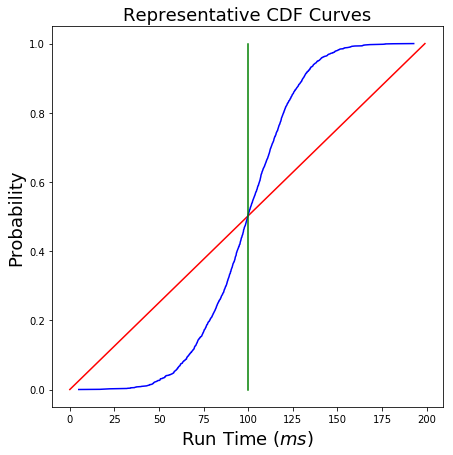

In [15]:
cdfplot("idealized", sigma=25.0)

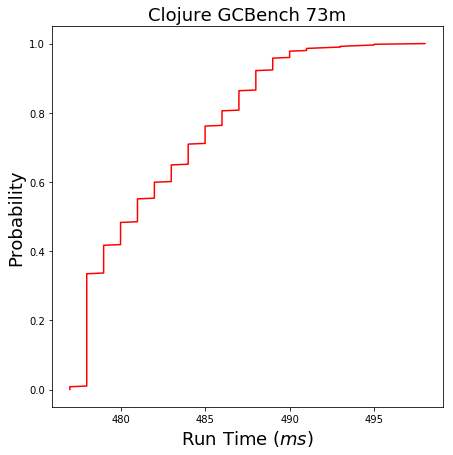

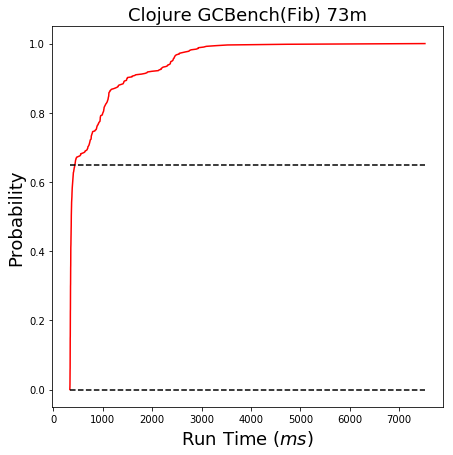

In [4]:
cdfplot("20170925-cloj-gcb-loop")
cdfplot("20170926-cloj-gcb-fib", VL=[0, .65])

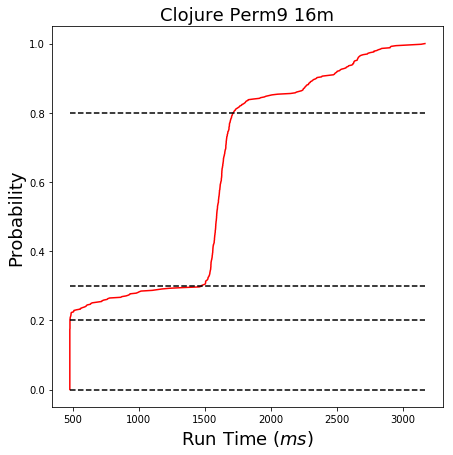

In [5]:
cdfplot("20170919-cloj-p9-loop", VL=[.30, .80, 0, .2])


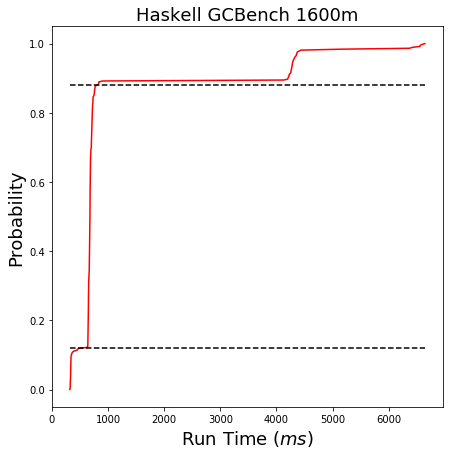

In [6]:
cdfplot("20170927-hask-gcb", VL=[.12, .88], RTDIV=0.001)


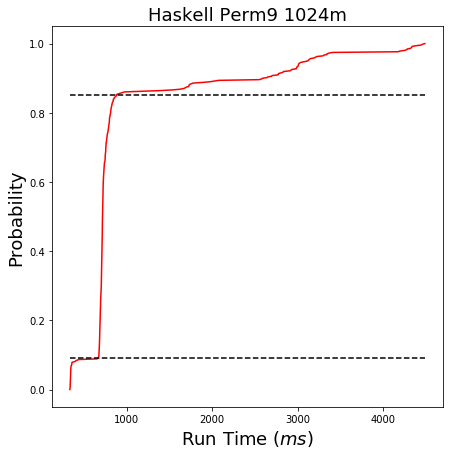

In [7]:
cdfplot("20170927-hask-p9", VL=[.09, .85], RTDIV=0.001)


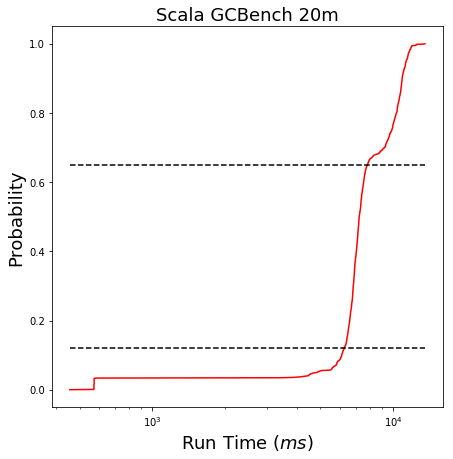

In [8]:
cdfplot("20170919-scala-gcb-loop", logs=True, VL=[.12, .65])

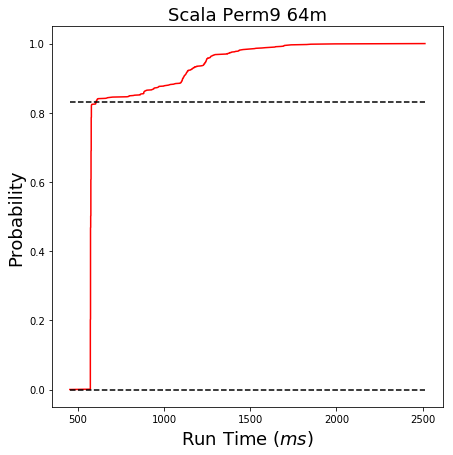

In [9]:
cdfplot("20170919-scala-p9-loop", VL=[.0, .83])

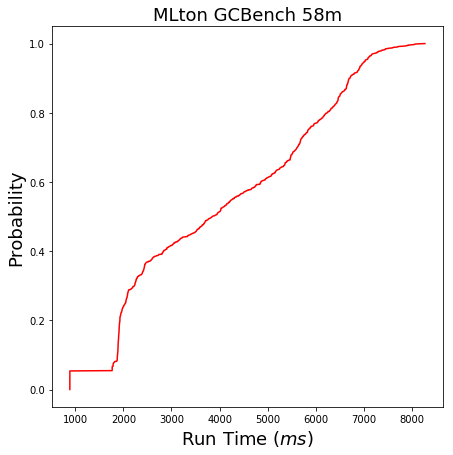

In [10]:
cdfplot("20170830-mlton-gcb")

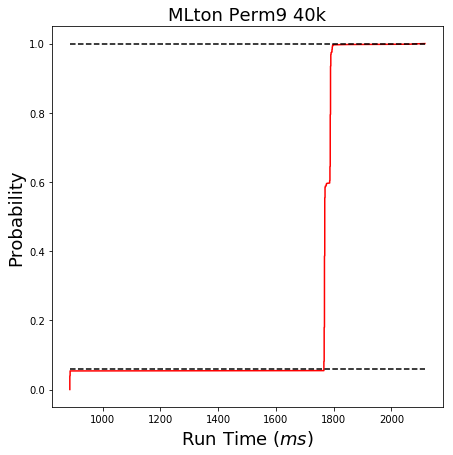

In [11]:
cdfplot("20170831-mlton-p9", VL=[.06, 1])